In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from kan import KAN, add_symbolic
from torch.utils.data import TensorDataset, DataLoader

# Load the dataset
data_path = 'RoofTypicalDays_Winter Typical.csv'
data = pd.read_csv(data_path)

# Define input and output columns
input_columns = ['Temp', 'Dew', 'Hum', 'Pres', 'Area', 'u-Value (Roof)', 'Heat Capacity']
output_column = 'Winter Typical:Heat Flow'
num_tasks = 3

# Prepare the data
X = data[input_columns].values
y = data[output_column].values

# Define subsampling rates
subsample_rates = [1, 0.5, 0.25, 0.1]

# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(X.shape[1], 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Train the ANN model with early stopping
def train_ann(model, train_loader, val_loader, criterion, optimizer, epochs=200, patience=10):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

# Evaluate the ANN model
def evaluate_ann(model, X_tensors, y_tensors):
    model.eval()
    all_predictions = []
    all_actuals = []
    with torch.no_grad():
        for X, y in zip(X_tensors, y_tensors):
            outputs = model(X)
            all_predictions.append(outputs.numpy())
            all_actuals.append(y.numpy())
    return all_predictions, all_actuals

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

# Train the KAN model using the tutorial's approach with early stopping
def train_kan_with_early_stopping(model, dataset, patience=5, steps=200):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    optimizer = torch.optim.LBFGS(model.parameters(), lr=1)

    def closure():
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        return loss

    for step in range(steps):
        optimizer.step(closure)
        
        # Validation step
        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

# Function to train and evaluate models on each subsample rate
def train_and_evaluate_models(subsample_rate, X, y, seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Subsample the data
    if subsample_rate < 1:
        X_sub, _, y_sub, _ = train_test_split(X, y, test_size=1 - subsample_rate, random_state=seed)
    else:
        X_sub, y_sub = X, y

    # Split the dataset into multiple tasks
    X_splits = np.array_split(X_sub, num_tasks)
    y_splits = np.array_split(y_sub, num_tasks)

    # Normalize the data using only the first task's statistics
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit scalers on Task 1 data only
    X_task1_scaled = scaler_X.fit_transform(X_splits[0])
    y_task1_scaled = scaler_y.fit_transform(y_splits[0].reshape(-1, 1)).flatten()

    # Apply the scalers to all tasks
    X_splits_scaled = [X_task1_scaled] + [scaler_X.transform(X_split) for X_split in X_splits[1:]]
    y_splits_scaled = [y_task1_scaled] + [scaler_y.transform(y_split.reshape(-1, 1)).flatten() for y_split in y_splits[1:]]

    # Convert to tensors
    X_splits_tensors = [torch.tensor(X_split, dtype=torch.float32) for X_split in X_splits_scaled]
    y_splits_tensors = [torch.tensor(y_split, dtype=torch.float32).unsqueeze(1) for y_split in y_splits_scaled]

    # Initialize and train the ANN model on sequential tasks
    ann_model = ANN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

    ann_r2_scores = np.zeros((num_tasks, num_tasks))
    for task_id in range(num_tasks):
        # Split the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_splits_tensors[task_id], y_splits_tensors[task_id], test_size=0.2, random_state=seed)
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        train_ann(ann_model, train_loader, val_loader, criterion, optimizer, epochs=200, patience=10)

        # Evaluate ANN on all tasks
        all_predictions, all_actuals = evaluate_ann(ann_model, X_splits_tensors, y_splits_tensors)
        for i in range(num_tasks):
            _, _, r2 = calculate_metrics(all_predictions[i], all_actuals[i], y_std=scaler_y.scale_[0], y_mean=scaler_y.mean_[0])
            ann_r2_scores[task_id, i] = r2

    # Initialize and train the KAN model on sequential tasks
    kan_model = KAN(width=[len(input_columns), 5, 1], grid=10, k=10)

    kan_r2_scores = np.zeros((num_tasks, num_tasks))
    for task_id in range(num_tasks):
        # Split the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_splits_tensors[task_id], y_splits_tensors[task_id], test_size=0.2, random_state=seed)

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_val,
            'test_label': y_val
        }
        train_kan_with_early_stopping(kan_model, dataset, patience=3, steps=100)

        # Evaluate KAN on all tasks
        all_predictions_kan = []
        for X in X_splits_tensors:
            with torch.no_grad():
                predictions_kan_scaled = kan_model(X).numpy()
            all_predictions_kan.append(predictions_kan_scaled)

        for i in range(num_tasks):
            _, _, r2 = calculate_metrics(all_predictions_kan[i], y_splits_scaled[i], y_std=scaler_y.scale_[0], y_mean=scaler_y.mean_[0])
            kan_r2_scores[task_id, i] = r2

    return ann_r2_scores, kan_r2_scores

# Function to run multiple experiments
def run_multiple_experiments(num_runs=10):
    results = {
        'ANN': {rate: [] for rate in subsample_rates},
        'KAN': {rate: [] for rate in subsample_rates}
    }

    for run in range(num_runs):
        print(f"Running experiment {run + 1}/{num_runs}")
        for subsample_rate in subsample_rates:
            print(f"Subsample rate: {subsample_rate}")
            ann_r2_scores, kan_r2_scores = train_and_evaluate_models(subsample_rate, X, y, seed=run)
            results['ANN'][subsample_rate].append(ann_r2_scores)
            results['KAN'][subsample_rate].append(kan_r2_scores)

    return results

# Run the experiments
results = run_multiple_experiments(num_runs=10)

# Calculate average and standard deviation
avg_results = {model: {rate: np.mean(scores, axis=0) for rate, scores in model_results.items()} for model, model_results in results.items()}
std_results = {model: {rate: np.std(scores, axis=0) for rate, scores in model_results.items()} for model, model_results in results.items()}

# Function to format results as a string with mean and standard deviation
def format_result(mean, std):
    return f"{mean:.3f} ± {std:.3f}"

# Create a DataFrame to store the formatted results
columns = pd.MultiIndex.from_product([['After Task 1', 'After Task 2', 'After Task 3'], ['T1', 'T2', 'T3']])
index = pd.MultiIndex.from_product([['ANN', 'KAN'], subsample_rates])
df_results = pd.DataFrame(index=index, columns=columns)

# Fill the DataFrame with formatted results
for model in ['ANN', 'KAN']:
    for rate in subsample_rates:
        for task in range(3):
            for eval_task in range(3):
                mean = avg_results[model][rate][task, eval_task]
                std = std_results[model][rate][task, eval_task]
                df_results.loc[(model, rate), (f'After Task {task+1}', f'T{eval_task+1}')] = format_result(mean, std)

# Save the results to a CSV file
df_results.to_csv('continuous_learning_results.csv')

print("Results have been saved to 'continuous_learning_results.csv'")

# Print the results
print(df_results)

# Plot the average R² comparison for ANN and KAN with different subsample rates
for task_id in range(num_tasks):
    plt.figure(figsize=(14, 7))
    bar_width = 0.35
    index = np.arange(len(subsample_rates))

    ann_mean_r2 = [avg_results['ANN'][rate][task_id, task_id] for rate in subsample_rates]
    kan_mean_r2 = [avg_results['KAN'][rate][task_id, task_id] for rate in subsample_rates]
    ann_std_r2 = [std_results['ANN'][rate][task_id, task_id] for rate in subsample_rates]
    kan_std_r2 = [std_results['KAN'][rate][task_id, task_id] for rate in subsample_rates]

    plt.bar(index - bar_width / 2, ann_mean_r2, bar_width, yerr=ann_std_r2, label='ANN', capsize=5)
    plt.bar(index + bar_width / 2, kan_mean_r2, bar_width, yerr=kan_std_r2, label='KAN', capsize=5)

    plt.xlabel('Subsample Rate')
    plt.ylabel('R² Score')
    plt.title(f'Average R² Comparison of ANN and KAN with Different Subsample Rates for Task {task_id + 1}')
    plt.xticks(index, subsample_rates)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Average_R2_Comparison_Subsample_Rates_Task_{task_id + 1}.png', dpi=300)
    plt.close()

print("Plots have been saved as PNG files.")

Running experiment 1/10
Subsample rate: 1
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Subsample rate: 0.5
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Subsample rate: 0.25
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Subsample rate: 0.1
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Running experiment 2/10
Subsample rate: 1
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Subsample rate: 0.5
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stop

Plots have been saved as PNG files.


Running experiment 1/10
Subsample rate: 1
Subsample rate: 0.5
Subsample rate: 0.25
Subsample rate: 0.1
Subsample rate: 0.05
Running experiment 2/10
Subsample rate: 1
Subsample rate: 0.5
Subsample rate: 0.25
Subsample rate: 0.1
Subsample rate: 0.05
Running experiment 3/10
Subsample rate: 1
Subsample rate: 0.5
Subsample rate: 0.25
Subsample rate: 0.1
Subsample rate: 0.05
Running experiment 4/10
Subsample rate: 1
Subsample rate: 0.5
Subsample rate: 0.25
Subsample rate: 0.1
Subsample rate: 0.05
Running experiment 5/10
Subsample rate: 1
Subsample rate: 0.5
Subsample rate: 0.25
Subsample rate: 0.1
Subsample rate: 0.05
Running experiment 6/10
Subsample rate: 1
Subsample rate: 0.5
Subsample rate: 0.25
Subsample rate: 0.1
Subsample rate: 0.05
Running experiment 7/10
Subsample rate: 1
Subsample rate: 0.5
Subsample rate: 0.25
Subsample rate: 0.1
Subsample rate: 0.05
Running experiment 8/10
Subsample rate: 1
Subsample rate: 0.5
Subsample rate: 0.25
Subsample rate: 0.1
Subsample rate: 0.05
Running 

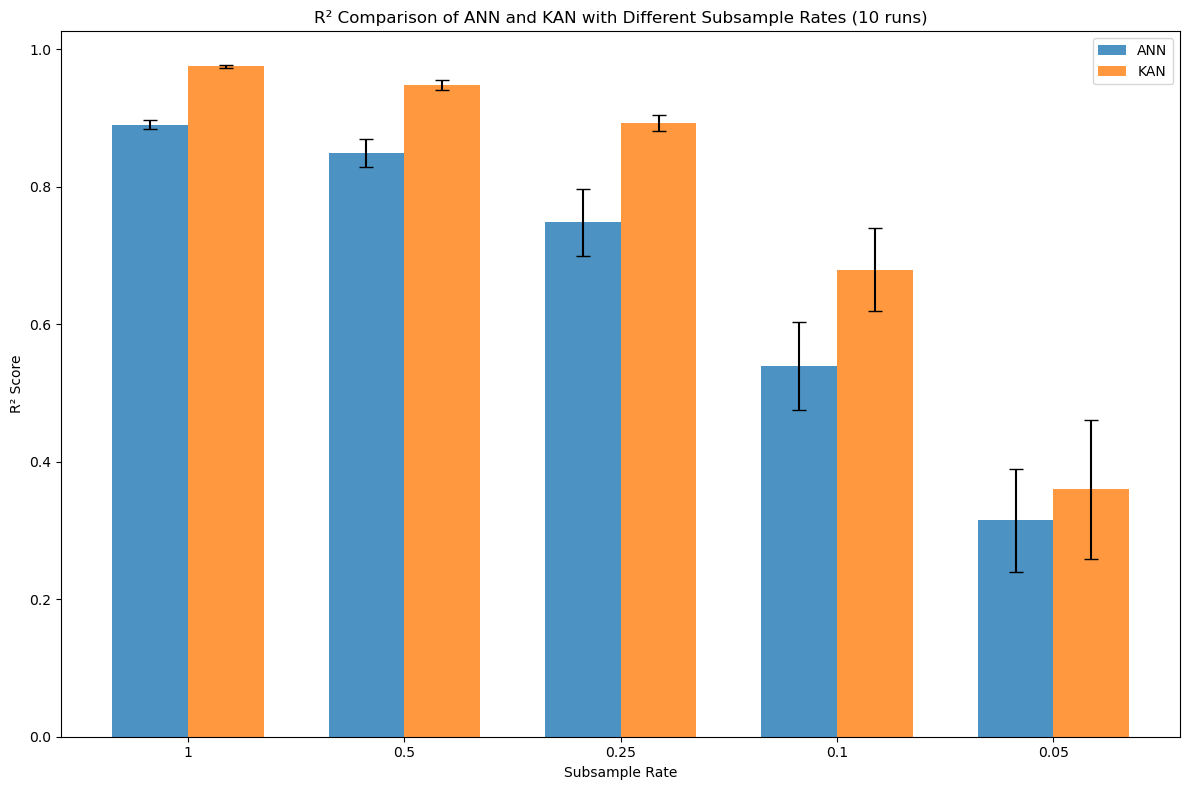

Results saved to 'R2_results_with_variance.csv'

Summary of Results:
   Subsample Rate Model   Mean R²    Std R²
0            1.00   ANN  0.890600  0.006600
1            0.50   ANN  0.849403  0.020287
2            0.25   ANN  0.748797  0.048798
3            0.10   ANN  0.539118  0.064301
4            0.05   ANN  0.314829  0.074484
5            1.00   KAN  0.975239  0.002191
6            0.50   KAN  0.948330  0.006914
7            0.25   KAN  0.892766  0.011631
8            0.10   KAN  0.679627  0.060058
9            0.05   KAN  0.359793  0.101125


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from kan import KAN, add_symbolic
from torch.utils.data import TensorDataset, DataLoader

# Load the dataset
data_path = 'RoofTypicalDays_Winter Typical.csv'
data = pd.read_csv(data_path)

# Define input and output columns
input_columns = ['Temp', 'Dew', 'Hum', 'Pres', 'Area', 'u-Value (Roof)', 'Heat Capacity']
output_column = 'Winter Typical:Heat Flow'
num_tasks = 3

# Prepare the data
X = data[input_columns].values
y = data[output_column].values

# Define subsampling rates
subsample_rates = [1, 0.5, 0.25, 0.1, 0.05]

# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(X.shape[1], 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Train the ANN model with early stopping
def train_ann(model, train_loader, val_loader, criterion, optimizer, epochs=200, patience=10):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

# Evaluate the ANN model
def evaluate_ann(model, test_loader):
    model.eval()
    all_predictions = []
    all_actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            all_predictions.append(outputs.numpy())
            all_actuals.append(targets.numpy())
    predictions = np.concatenate(all_predictions)
    actuals = np.concatenate(all_actuals)
    return predictions, actuals

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

# Train the KAN model using the tutorial's approach with early stopping
def train_kan_with_early_stopping(model, dataset, patience=5, steps=200):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    optimizer = torch.optim.LBFGS(model.parameters(), lr=1)

    def closure():
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        return loss

    for step in range(steps):
        optimizer.step(closure)
        
        # Validation step
        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

# Function to train and evaluate models on each subsample rate
def train_and_evaluate_models(subsample_rate, X, y, seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Subsample the data
    if subsample_rate < 1:
        X_sub, _, y_sub, _ = train_test_split(X, y, test_size=1 - subsample_rate, random_state=seed)
    else:
        X_sub, y_sub = X, y

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=seed)

    # Normalize the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize and train the ANN model
    ann_model = ANN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

    train_ann(ann_model, train_loader, test_loader, criterion, optimizer, epochs=200, patience=10)

    predictions_ann, actuals_ann = evaluate_ann(ann_model, test_loader)
    _, _, r2_ann = calculate_metrics(predictions_ann, actuals_ann, y_std=scaler_y.scale_[0], y_mean=scaler_y.mean_[0])

    # Initialize and train the KAN model
    kan_model = KAN(width=[len(input_columns), 20, 1], grid=10, k=10)
    dataset = {
        'train_input': X_train_tensor,
        'train_label': y_train_tensor,
        'test_input': X_test_tensor,
        'test_label': y_test_tensor
    }

    train_kan_with_early_stopping(kan_model, dataset, patience=3, steps=100)

    with torch.no_grad():
        predictions_kan_scaled = kan_model(X_test_tensor).numpy()
    _, _, r2_kan = calculate_metrics(predictions_kan_scaled, y_test_scaled, y_std=scaler_y.scale_[0], y_mean=scaler_y.mean_[0])

    return r2_ann, r2_kan

# Function to run multiple experiments
def run_multiple_experiments(num_runs=10):
    results = {
        'ANN': {rate: [] for rate in subsample_rates},
        'KAN': {rate: [] for rate in subsample_rates}
    }

    for run in range(num_runs):
        print(f"Running experiment {run + 1}/{num_runs}")
        for subsample_rate in subsample_rates:
            print(f"Subsample rate: {subsample_rate}")
            r2_ann, r2_kan = train_and_evaluate_models(subsample_rate, X, y, seed=run)
            results['ANN'][subsample_rate].append(r2_ann)
            results['KAN'][subsample_rate].append(r2_kan)

    return results

# Run the experiments
results = run_multiple_experiments(num_runs=10)

# Calculate mean and standard deviation
mean_results = {model: {rate: np.mean(scores) for rate, scores in model_results.items()} for model, model_results in results.items()}
std_results = {model: {rate: np.std(scores) for rate, scores in model_results.items()} for model, model_results in results.items()}

# Plot the R² comparison for ANN and KAN with different subsample rates, including variance
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(subsample_rates))

for i, model in enumerate(['ANN', 'KAN']):
    means = [mean_results[model][rate] for rate in subsample_rates]
    stds = [std_results[model][rate] for rate in subsample_rates]
    plt.bar(index + i*bar_width, means, bar_width, label=model,
            yerr=stds, capsize=5, alpha=0.8)

plt.xlabel('Subsample Rate')
plt.ylabel('R² Score')
plt.title('R² Comparison of ANN and KAN with Different Subsample Rates (10 runs)')
plt.xticks(index + bar_width / 2, subsample_rates)
plt.legend()
plt.tight_layout()
plt.savefig('R2_Comparison_Subsample_Rates_with_Variance.png', dpi=300)
plt.show()

# Save results to CSV
results_df = pd.DataFrame({
    'Subsample Rate': subsample_rates * 2,
    'Model': ['ANN'] * len(subsample_rates) + ['KAN'] * len(subsample_rates),
    'Mean R²': [mean_results['ANN'][rate] for rate in subsample_rates] + [mean_results['KAN'][rate] for rate in subsample_rates],
    'Std R²': [std_results['ANN'][rate] for rate in subsample_rates] + [std_results['KAN'][rate] for rate in subsample_rates]
})

results_df.to_csv('R2_results_with_variance.csv', index=False)
print("Results saved to 'R2_results_with_variance.csv'")

# Print summary of results
print("\nSummary of Results:")
print(results_df)

C:\Users\msi-\AppData\Local\Temp\ipykernel_22316\3189282486.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


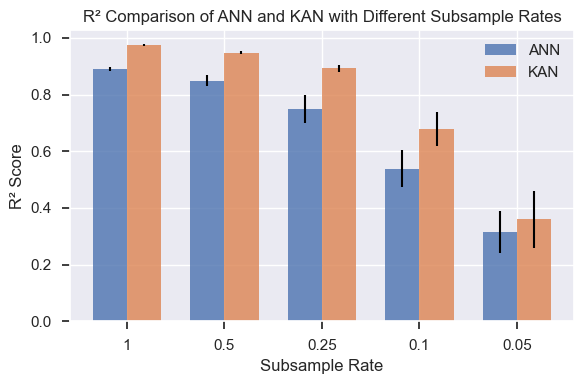

In [12]:
import seaborn as sns
# 设置全局样式
plt.style.use('seaborn')
sns.set_context("notebook")
sns.set_palette("deep")
# Plot the R² comparison for ANN and KAN with different subsample rates, including variance
plt.figure(figsize=(6, 4))
bar_width = 0.35
index = np.arange(len(subsample_rates))

for i, model in enumerate(['ANN', 'KAN']):
    means = [mean_results[model][rate] for rate in subsample_rates]
    stds = [std_results[model][rate] for rate in subsample_rates]
    plt.bar(index + i*bar_width, means, bar_width, label=model,
            yerr=stds, capsize=5, alpha=0.8)

plt.xlabel('Subsample Rate')
plt.ylabel('R² Score')
plt.title('R² Comparison of ANN and KAN with Different Subsample Rates')
plt.xticks(index + bar_width / 2, subsample_rates)
plt.legend()
plt.tight_layout()
plt.savefig('R2_Comparison_Subsample_Rates_with_Variance.png', dpi=400)
plt.show()

In [20]:
from graphviz import Digraph

# Create a new Digraph object
dot = Digraph(comment='KAN in Building Physics and Decision Tree')

# Set global graph attributes
dot.attr(rankdir='TB', size='14,20', dpi='300', fontname='Arial', fontsize='14')
dot.attr('node', shape='rectangle', style='filled', fontname='Arial', fontsize='12', margin='0.2,0.1')
dot.attr('edge', color='#4a4a4a', fontname='Arial', fontsize='10', penwidth='1.2')

# Define color scheme
decision_color = '#e6f3ff'
kan_color = '#90EE90'
ann_color = '#ADD8E6'
hybrid_color = '#FFFACD'
reassess_color = '#D3D3D3'

# Create main title
dot.attr('node', shape='none', fontsize='24', fontcolor='#1a5f7a')
dot.node('Title', 'KAN in Building Physics')

# Create subgraph for application areas
with dot.subgraph(name='cluster_applications') as c:
    c.attr(label='Application Areas')
    c.node('Energy', 'Energy Modeling', fillcolor=decision_color)
    c.node('Thermal', 'Thermal Comfort\nPrediction', fillcolor=decision_color)
    c.node('IAQ', 'Indoor Air Quality\nAnalysis', fillcolor=decision_color)
    c.node('Performance', 'Building Performance\nOptimization', fillcolor=decision_color)

# Create decision tree nodes
dot.attr('node', shape='diamond')
decision_nodes = {
    'A': 'Data Availability',
    'B': 'Problem Complexity',
    'C': 'Interpretability\nRequirements',
    'D': 'Dynamic Nature',
    'E': 'Extreme Value\nPrediction',
    'F': 'Transfer Learning',
    'G': 'Computational\nResources',
    'H': 'Continuous Learning',
    'I': 'Underlying\nRelationships',
    'J': 'Real-time\nPerformance'
}

for key, label in decision_nodes.items():
    dot.node(key, label, fillcolor=decision_color)

# Create leaf nodes
dot.attr('node', shape='rectangle')
dot.node('KAN', 'KAN', fillcolor=kan_color)
dot.node('ANN', 'ANN', fillcolor=ann_color)
dot.node('HYBRID', 'Hybrid Approach', fillcolor=hybrid_color)
dot.node('REASSESS', 'Reassess with\nData Augmentation', fillcolor=reassess_color)

# Connect application areas to decision tree
dot.edge('Title', 'Energy')
dot.edge('Title', 'Thermal')
dot.edge('Title', 'IAQ')
dot.edge('Title', 'Performance')
dot.edge('Energy', 'A', 'Consider')
dot.edge('Thermal', 'A', 'Consider')
dot.edge('IAQ', 'A', 'Consider')
dot.edge('Performance', 'A', 'Consider')

# Create decision tree edges
edges = [
    ('A', 'KAN', 'Limited\nNeed Interpretability'),
    ('A', 'REASSESS', 'Limited\nNo Interpretability Need'),
    ('A', 'B', 'Abundant'),
    ('B', 'KAN', 'Simple'),
    ('B', 'C', 'Complex'),
    ('C', 'KAN', 'High'),
    ('C', 'D', 'Low to Medium'),
    ('D', 'KAN', 'Highly Dynamic'),
    ('D', 'E', 'Stable'),
    ('E', 'KAN', 'Critical'),
    ('E', 'F', 'Not Critical'),
    ('F', 'ANN', 'High'),
    ('F', 'G', 'Low'),
    ('G', 'ANN', 'Limited'),
    ('G', 'H', 'Abundant'),
    ('H', 'HYBRID', 'High'),
    ('H', 'I', 'Low'),
    ('I', 'KAN', 'High'),
    ('I', 'J', 'Low'),
    ('J', 'ANN', 'Critical'),
    ('J', 'KAN', 'Not Critical')
]

for edge in edges:
    dot.edge(*edge)

# Render the graph
dot.render('comprehensive_kan_building_physics', format='png', cleanup=True)
print("Comprehensive KAN in Building Physics diagram has been generated as 'comprehensive_kan_building_physics.png'")

Comprehensive KAN in Building Physics diagram has been generated as 'comprehensive_kan_building_physics.png'
